In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt

## Učitavanje podataka

In [12]:
data = pd.read_csv('data.csv')

In [13]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [14]:
y = data.iloc[:, -1]
X = data.iloc[:, :data.shape[1] - 1]

### Pravljenje atributa i metrika za evaluaciju i izbor najboljeg modela

In [15]:
cnn_par_f = {
    'window': [7, 11, 13],
    'dropout': [0.5, 0.6, 0.7, 0.8]
}

In [16]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [17]:
filter_cnn = 64
num_classes = len(np.unique(y))
epochs = 25
K=10
pool = 3
classes = np.unique(y)

In [18]:
num_classes

5

In [19]:
scoring = {'f1_macro' : 'f1_macro', 'accuracy' : 'accuracy'}
for c in classes:
    def f1_class(y_true, y_pred, classes, c=c):
        return metrics.f1_score(y_true, y_pred, average=None)[c-1]
    scoring_name = 'f1_class_%d' % c
    scoring[scoring_name] = metrics.make_scorer(f1_class, classes = classes)

### Podela podataka na trening i testni skup, standardizacija i Furijeova transformacija

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, stratify = y,random_state = 1996)

In [21]:
from sklearn import preprocessing
scaler_train = preprocessing.StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)
X_test = scaler_train.transform(X_test)

In [22]:
print(X_train.shape, X_test.shape)

(8050, 178) (3450, 178)


In [23]:
X_train_fft = np.fft.rfft(X_train, axis=1).astype(float)
X_test_fft = np.fft.rfft(X_test, axis=1).astype(float)

C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [24]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90) (3450, 90)


In [25]:
X_train_fft = np.array(X_train_fft)
X_test_fft = np.array(X_test_fft)
X_train_fft = X_train_fft.reshape(X_train_fft.shape[0], X_train_fft.shape[1], 1)
X_test_fft = X_test_fft.reshape(X_test_fft.shape[0], X_test_fft.shape[1], 1)

In [26]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90, 1) (3450, 90, 1)


## Pravljenje mreže i izbor najboljeg modela unakrsnom validacijom

In [27]:
input_shape = (X_train_fft.shape[1], 1)
input_shape

(90, 1)

In [28]:
def mreza(input_shape, num_classes,window, dropout):
    model = Sequential()
    model.add(Conv1D(filter_cnn, window, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filter_cnn, window, activation='relu'))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
from keras.wrappers.scikit_learn  import KerasClassifier
def get_estimator(window=3,dropout=0.5):
    return KerasClassifier(build_fn=mreza,input_shape=input_shape, num_classes=num_classes,window=window, dropout=dropout, epochs = epochs)

In [30]:
estimator = get_estimator()
grid_f_cnn = model_selection.GridSearchCV(estimator, param_grid=cnn_par_f, scoring=scoring, cv=K, refit='accuracy', return_train_score=True)

In [31]:
grid_f_cnn.fit(X_train_fft, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
7245/7245 [==============================] - 5s 707us/step - loss: 1.1316 - accuracy: 0.4871
Epoch 2/25
7245/7245 [==============================] - 5s 641us/step - loss: 0.8789 - accuracy: 0.6057
Epoch 3/25
7245/7245 [==============================] - 5s 638us/step - loss: 0.7859 - accuracy: 0.6407
Epoch 4/25
7245/7245 [==============================] - 5s 638us/step - loss: 0.7224 - accuracy: 0.6703
Epoch 5/25
7245/7245 [==============================] - 5s 645us/step - loss: 0.6935 - accuracy: 0.6780
Epoch 6/25
7245/7245 [==============================] - 5s 646us/step - loss: 0.6755 - accuracy: 0.6841
Epoch 7/25
7245/7245 [==============================] - 5s 640us/step - loss: 0.6585 - accuracy: 0.6954
Epoch 8/25
7245/7245 [==============================] - 5s 646us/step - loss: 0.6364 - accuracy: 0.7006
Epoch 9/25
7245/7245 [==========================

7245/7245 [==============================] - 5s 668us/step - loss: 1.1227 - accuracy: 0.4860
Epoch 2/25
7245/7245 [==============================] - 4s 621us/step - loss: 0.8452 - accuracy: 0.6255
Epoch 3/25
7245/7245 [==============================] - 5s 630us/step - loss: 0.7838 - accuracy: 0.6447
Epoch 4/25
7245/7245 [==============================] - 5s 622us/step - loss: 0.7141 - accuracy: 0.6781
Epoch 5/25
7245/7245 [==============================] - 4s 610us/step - loss: 0.6923 - accuracy: 0.6766
Epoch 6/25
7245/7245 [==============================] - 4s 621us/step - loss: 0.6593 - accuracy: 0.6925
Epoch 7/25
7245/7245 [==============================] - 5s 629us/step - loss: 0.6431 - accuracy: 0.6999
Epoch 8/25
7245/7245 [==============================] - 4s 621us/step - loss: 0.6120 - accuracy: 0.7053
Epoch 9/25
7245/7245 [==============================] - 5s 626us/step - loss: 0.6013 - accuracy: 0.7190
Epoch 10/25
7245/7245 [==============================] - 5s 629us/step - lo

7245/7245 [==============================] - 5s 630us/step - loss: 0.7246 - accuracy: 0.6761
Epoch 5/25
7245/7245 [==============================] - 5s 626us/step - loss: 0.6741 - accuracy: 0.6857
Epoch 6/25
7245/7245 [==============================] - 5s 631us/step - loss: 0.6658 - accuracy: 0.6901
Epoch 7/25
7245/7245 [==============================] - 5s 630us/step - loss: 0.6351 - accuracy: 0.6976
Epoch 8/25
7245/7245 [==============================] - 5s 630us/step - loss: 0.6149 - accuracy: 0.7110
Epoch 9/25
7245/7245 [==============================] - 5s 628us/step - loss: 0.6059 - accuracy: 0.7111
Epoch 10/25
7245/7245 [==============================] - 5s 628us/step - loss: 0.5837 - accuracy: 0.7180
Epoch 11/25
7245/7245 [==============================] - 5s 628us/step - loss: 0.5715 - accuracy: 0.7293
Epoch 12/25
7245/7245 [==============================] - 5s 630us/step - loss: 0.5496 - accuracy: 0.7380
Epoch 13/25
7245/7245 [==============================] - 5s 629us/step -

7245/7245 [==============================] - 5s 703us/step - loss: 0.4887 - accuracy: 0.7623
Epoch 11/25
7245/7245 [==============================] - 5s 702us/step - loss: 0.4800 - accuracy: 0.7652
Epoch 12/25
7245/7245 [==============================] - 5s 704us/step - loss: 0.4453 - accuracy: 0.7774
Epoch 13/25
7245/7245 [==============================] - 5s 703us/step - loss: 0.4320 - accuracy: 0.7821
Epoch 14/25
7245/7245 [==============================] - 5s 698us/step - loss: 0.4348 - accuracy: 0.7814
Epoch 15/25
7245/7245 [==============================] - 5s 705us/step - loss: 0.4003 - accuracy: 0.7974
Epoch 16/25
7245/7245 [==============================] - 5s 701us/step - loss: 0.3826 - accuracy: 0.8127
Epoch 17/25
7245/7245 [==============================] - 5s 689us/step - loss: 0.3625 - accuracy: 0.8199
Epoch 18/25
7245/7245 [==============================] - 5s 687us/step - loss: 0.3751 - accuracy: 0.8153
Epoch 19/25
7245/7245 [==============================] - 5s 686us/s

C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_84/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_88/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

Epoch 1/25
7245/7245 [==============================] - 6s 777us/step - loss: 1.1590 - accuracy: 0.4741
Epoch 2/25
7245/7245 [==============================] - 5s 699us/step - loss: 0.9072 - accuracy: 0.6036
Epoch 3/25
7245/7245 [==============================] - 5s 696us/step - loss: 0.8255 - accuracy: 0.6326
Epoch 4/25
7245/7245 [==============================] - 5s 699us/step - loss: 0.7699 - accuracy: 0.6574
Epoch 5/25
7245/7245 [==============================] - 5s 698us/step - loss: 0.7312 - accuracy: 0.6635
Epoch 6/25
7245/7245 [==============================] - 5s 698us/step - loss: 0.6793 - accuracy: 0.6847
Epoch 7/25
7245/7245 [==============================] - 5s 699us/step - loss: 0.6619 - accuracy: 0.6974
Epoch 8/25
7245/7245 [==============================] - 5s 699us/step - loss: 0.6508 - accuracy: 0.6992
Epoch 9/25
7245/7245 [==============================] - 5s 698us/step - loss: 0.6257 - accuracy: 0.7101
Epoch 10/25
7245/7245 [==============================] - 5s 699u

7245/7245 [==============================] - 5s 754us/step - loss: 0.6496 - accuracy: 0.6905
Epoch 8/25
7245/7245 [==============================] - 5s 740us/step - loss: 0.6350 - accuracy: 0.7002
Epoch 9/25
7245/7245 [==============================] - 5s 740us/step - loss: 0.6226 - accuracy: 0.7074
Epoch 10/25
7245/7245 [==============================] - 5s 747us/step - loss: 0.5987 - accuracy: 0.7155
Epoch 11/25
7245/7245 [==============================] - 5s 746us/step - loss: 0.6240 - accuracy: 0.7125
Epoch 12/25
7245/7245 [==============================] - 5s 740us/step - loss: 0.5806 - accuracy: 0.7268
Epoch 13/25
7245/7245 [==============================] - 5s 745us/step - loss: 0.5670 - accuracy: 0.7274
Epoch 14/25
7245/7245 [==============================] - 5s 742us/step - loss: 0.5521 - accuracy: 0.7361
Epoch 15/25
7245/7245 [==============================] - 5s 746us/step - loss: 0.5364 - accuracy: 0.7383
Epoch 16/25
7245/7245 [==============================] - 5s 741us/ste

7245/7245 [==============================] - 6s 818us/step - loss: 0.4929 - accuracy: 0.7520
Epoch 14/25
7245/7245 [==============================] - 6s 817us/step - loss: 0.5021 - accuracy: 0.7492
Epoch 15/25
7245/7245 [==============================] - 6s 820us/step - loss: 0.4729 - accuracy: 0.7626
Epoch 16/25
7245/7245 [==============================] - 6s 817us/step - loss: 0.4503 - accuracy: 0.7648
Epoch 17/25
7245/7245 [==============================] - 6s 818us/step - loss: 0.4329 - accuracy: 0.7757
Epoch 18/25
7245/7245 [==============================] - 6s 814us/step - loss: 0.4119 - accuracy: 0.7837
Epoch 19/25
7245/7245 [==============================] - 6s 817us/step - loss: 0.4221 - accuracy: 0.7855
Epoch 20/25
7245/7245 [==============================] - 6s 818us/step - loss: 0.3932 - accuracy: 0.7983
Epoch 21/25
7245/7245 [==============================] - 6s 813us/step - loss: 0.3720 - accuracy: 0.8057
Epoch 22/25
7245/7245 [==============================] - 6s 815us/s

7245/7245 [==============================] - 6s 867us/step - loss: 0.3978 - accuracy: 0.8033
Epoch 20/25
7245/7245 [==============================] - 6s 867us/step - loss: 0.3992 - accuracy: 0.8006
Epoch 21/25
7245/7245 [==============================] - 6s 866us/step - loss: 0.3600 - accuracy: 0.8150
Epoch 22/25
7245/7245 [==============================] - 6s 862us/step - loss: 0.3503 - accuracy: 0.8233
Epoch 23/25
7245/7245 [==============================] - 6s 863us/step - loss: 0.3856 - accuracy: 0.8081
Epoch 24/25
7245/7245 [==============================] - 6s 866us/step - loss: 0.3455 - accuracy: 0.8240
Epoch 25/25
7245/7245 [==============================] - 6s 862us/step - loss: 0.3349 - accuracy: 0.8327
Epoch 1/25
7245/7245 [==============================] - 7s 1ms/step - loss: 1.0559 - accuracy: 0.5256
Epoch 2/25
7245/7245 [==============================] - 6s 894us/step - loss: 0.7728 - accuracy: 0.6458
Epoch 3/25
7245/7245 [==============================] - 6s 887us/step -

C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_204/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_208/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for t

Epoch 1/25
7245/7245 [==============================] - 7s 971us/step - loss: 1.2246 - accuracy: 0.4338
Epoch 2/25
7245/7245 [==============================] - 6s 851us/step - loss: 0.9867 - accuracy: 0.5579
Epoch 3/25
7245/7245 [==============================] - 6s 840us/step - loss: 0.8856 - accuracy: 0.6076
Epoch 4/25
7245/7245 [==============================] - 6s 836us/step - loss: 0.8034 - accuracy: 0.6353
Epoch 5/25
7245/7245 [==============================] - 6s 834us/step - loss: 0.7937 - accuracy: 0.6475
Epoch 6/25
7245/7245 [==============================] - 6s 836us/step - loss: 0.7317 - accuracy: 0.6719
Epoch 7/25
7245/7245 [==============================] - 6s 836us/step - loss: 0.7060 - accuracy: 0.6859
Epoch 8/25
7245/7245 [==============================] - 6s 843us/step - loss: 0.6857 - accuracy: 0.6806
Epoch 9/25
7245/7245 [==============================] - 6s 841us/step - loss: 0.6727 - accuracy: 0.6912
Epoch 10/25
7245/7245 [==============================] - 6s 838u

7245/7245 [==============================] - 6s 891us/step - loss: 0.7229 - accuracy: 0.6720
Epoch 8/25
7245/7245 [==============================] - 6s 888us/step - loss: 0.7039 - accuracy: 0.6794
Epoch 9/25
7245/7245 [==============================] - 6s 893us/step - loss: 0.6731 - accuracy: 0.6915
Epoch 10/25
7245/7245 [==============================] - 6s 888us/step - loss: 0.6665 - accuracy: 0.6980
Epoch 11/25
7245/7245 [==============================] - 7s 901us/step - loss: 0.6323 - accuracy: 0.6981
Epoch 12/25
7245/7245 [==============================] - 6s 890us/step - loss: 0.6291 - accuracy: 0.7061
Epoch 13/25
7245/7245 [==============================] - 6s 888us/step - loss: 0.6012 - accuracy: 0.7204
Epoch 14/25
7245/7245 [==============================] - 6s 890us/step - loss: 0.5807 - accuracy: 0.7249
Epoch 15/25
7245/7245 [==============================] - 6s 887us/step - loss: 0.5773 - accuracy: 0.7291
Epoch 16/25
7245/7245 [==============================] - 6s 887us/ste

7245/7245 [==============================] - 7s 969us/step - loss: 0.4989 - accuracy: 0.7542
Epoch 14/25
7245/7245 [==============================] - 7s 965us/step - loss: 0.4991 - accuracy: 0.7513
Epoch 15/25
7245/7245 [==============================] - 7s 961us/step - loss: 0.4796 - accuracy: 0.7585
Epoch 16/25
7245/7245 [==============================] - 7s 963us/step - loss: 0.4483 - accuracy: 0.7783
Epoch 17/25
7245/7245 [==============================] - 7s 965us/step - loss: 0.4347 - accuracy: 0.7819
Epoch 18/25
7245/7245 [==============================] - 7s 969us/step - loss: 0.4314 - accuracy: 0.7839
Epoch 19/25
7245/7245 [==============================] - 7s 966us/step - loss: 0.4729 - accuracy: 0.7714
Epoch 20/25
7245/7245 [==============================] - 7s 967us/step - loss: 0.4089 - accuracy: 0.7910
Epoch 21/25
7245/7245 [==============================] - 7s 968us/step - loss: 0.3949 - accuracy: 0.7977
Epoch 22/25
7245/7245 [==============================] - 7s 967us/s

7245/7245 [==============================] - 7s 1ms/step - loss: 0.4033 - accuracy: 0.7920
Epoch 21/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.4158 - accuracy: 0.7890
Epoch 22/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.3689 - accuracy: 0.8112
Epoch 23/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.3602 - accuracy: 0.8094
Epoch 24/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.3346 - accuracy: 0.8283
Epoch 25/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.3323 - accuracy: 0.8240
Epoch 1/25
7245/7245 [==============================] - 9s 1ms/step - loss: 1.1204 - accuracy: 0.4908
Epoch 2/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.8172 - accuracy: 0.6331
Epoch 3/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7125 - accuracy: 0.6733
Epoch 4/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6748 - acc

C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_324/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_328/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for t

Epoch 1/25
7245/7245 [==============================] - 9s 1ms/step - loss: 1.2735 - accuracy: 0.4047
Epoch 2/25
7245/7245 [==============================] - 8s 1ms/step - loss: 1.0335 - accuracy: 0.5434
Epoch 3/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.9340 - accuracy: 0.5895
Epoch 4/25
7245/7245 [==============================] - 7s 1ms/step - loss: 0.8970 - accuracy: 0.6030
Epoch 5/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.8574 - accuracy: 0.6087
Epoch 6/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.8053 - accuracy: 0.6330
Epoch 7/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7771 - accuracy: 0.6461
Epoch 8/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7458 - accuracy: 0.6638
Epoch 9/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7373 - accuracy: 0.6668
Epoch 10/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.722

7245/7245 [==============================] - 8s 1ms/step - loss: 0.7441 - accuracy: 0.6654
Epoch 10/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7257 - accuracy: 0.6776
Epoch 11/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7122 - accuracy: 0.6712
Epoch 12/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6947 - accuracy: 0.6817
Epoch 13/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6618 - accuracy: 0.6899
Epoch 14/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6554 - accuracy: 0.6981
Epoch 15/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6407 - accuracy: 0.7021
Epoch 16/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6424 - accuracy: 0.7005
Epoch 17/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6203 - accuracy: 0.7071
Epoch 18/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.6091 -

7245/7245 [==============================] - 8s 1ms/step - loss: 0.5552 - accuracy: 0.7191
Epoch 18/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5464 - accuracy: 0.7228
Epoch 19/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5325 - accuracy: 0.7398
Epoch 20/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.5042 - accuracy: 0.7384
Epoch 21/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4900 - accuracy: 0.7498
Epoch 22/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4753 - accuracy: 0.7522
Epoch 23/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4702 - accuracy: 0.7575
Epoch 24/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4499 - accuracy: 0.7667
Epoch 25/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.4341 - accuracy: 0.7779
Epoch 1/25
7245/7245 [==============================] - 10s 1ms/step - loss: 1.2510 -

7245/7245 [==============================] - 9s 1ms/step - loss: 0.4468 - accuracy: 0.7696
Epoch 1/25
7245/7245 [==============================] - 10s 1ms/step - loss: 1.2426 - accuracy: 0.4236
Epoch 2/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.9087 - accuracy: 0.5919
Epoch 3/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7837 - accuracy: 0.6420
Epoch 4/25
7245/7245 [==============================] - 8s 1ms/step - loss: 0.7405 - accuracy: 0.6628
Epoch 5/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.7182 - accuracy: 0.6714
Epoch 6/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.6789 - accuracy: 0.6776
Epoch 7/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.6745 - accuracy: 0.6777
Epoch 8/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.6623 - accuracy: 0.6908
Epoch 9/25
7245/7245 [==============================] - 9s 1ms/step - loss: 0.6353 - accurac

C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_444/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative dimension size caused by subtracting 13 from 10 for 'conv1d_448/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,10,128], [1,13,128,128].

  FitFailedWarning)
C:\Users\vbakarevic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for t

Epoch 1/25
8050/8050 [==============================] - 12s 1ms/step - loss: 1.0058 - accuracy: 0.5415
Epoch 2/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.7043 - accuracy: 0.6774
Epoch 3/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.6507 - accuracy: 0.6958
Epoch 4/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.6055 - accuracy: 0.7047
Epoch 5/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.5907 - accuracy: 0.7106
Epoch 6/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.5636 - accuracy: 0.7308
Epoch 7/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.5641 - accuracy: 0.7286
Epoch 8/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.5373 - accuracy: 0.7405
Epoch 9/25
8050/8050 [==============================] - 10s 1ms/step - loss: 0.5097 - accuracy: 0.7503
Epoch 10/25
8050/8050 [==============================] - 10s 1ms/step - l

GridSearchCV(cv=10, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002641AE5F9B0>,
             iid='deprecated', n_jobs=None,
             param_grid={'dropout': [0.5, 0.6, 0.7, 0.8],
                         'window': [7, 11, 13]},
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'f1_class_1': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_2': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_3': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_4': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_class_5': make_scorer(f1_class, classes=[1 2 3 4 5]),
                      'f1_macro': 'f1_macro'},
             verbose=0)

In [32]:
grid_f_cnn.best_params_

{'dropout': 0.5, 'window': 11}

In [33]:
grid_f_cnn.best_score_

0.7411180124223602

### Rezultati unakrsne validacije

In [34]:
grid_f_cnn_results =pd.DataFrame(grid_f_cnn.cv_results_)
print(grid_f_cnn_results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      115.996258      2.837117         0.312300        0.086908   
1      129.444626      2.748952         0.667287        0.112002   
2        0.087706      0.000786         0.000000        0.000000   
3      140.547435      5.280578         1.150280        0.130313   
4      159.213202      4.292668         1.632778        0.142450   
5        0.087098      0.000947         0.000000        0.000000   
6      168.458645      5.262194         2.246757        0.168909   
7      192.448526      6.698728         2.833050        0.168037   
8        0.087700      0.000640         0.000000        0.000000   
9      206.324180      4.646053         3.565238        0.187350   
10     225.560345      3.746179         4.196824        0.189922   
11       0.088200      0.001536         0.000000        0.000000   

   param_dropout param_window                          params  \
0            0.5            7   {'dropout': 0.5, '

In [35]:
grid_f_cnn_results.to_csv('grid_f_cnn_new_scoring_results.csv')

In [36]:
grid_f_cnn_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_window,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,...,split2_train_f1_class_5,split3_train_f1_class_5,split4_train_f1_class_5,split5_train_f1_class_5,split6_train_f1_class_5,split7_train_f1_class_5,split8_train_f1_class_5,split9_train_f1_class_5,mean_train_f1_class_5,std_train_f1_class_5
0,115.996258,2.837117,0.312300,0.086908,0.5,7,"{'dropout': 0.5, 'window': 7}",0.728151,0.745031,0.754335,...,0.949948,0.963398,0.942138,0.939719,0.955285,0.924227,0.925718,0.955601,0.943681,0.012629
1,129.444626,2.748952,0.667287,0.112002,0.5,11,"{'dropout': 0.5, 'window': 11}",0.710907,0.740601,0.730406,...,0.988260,0.979898,0.989481,0.972878,0.982564,0.984531,0.986593,0.989064,0.982030,0.007057
2,0.087706,0.000786,0.000000,0.000000,0.5,13,"{'dropout': 0.5, 'window': 13}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,140.547435,5.280578,1.150280,0.130313,0.6,7,"{'dropout': 0.6, 'window': 7}",0.718918,0.710910,0.736053,...,0.924933,0.915129,0.926591,0.923336,0.926205,0.915768,0.924686,0.897723,0.915238,0.023749
4,159.213202,4.292668,1.632778,0.142450,0.6,11,"{'dropout': 0.6, 'window': 11}",0.713663,0.727714,0.732294,...,0.965963,0.975017,0.972828,0.976362,0.984203,0.982167,0.963188,0.980978,0.971850,0.009049


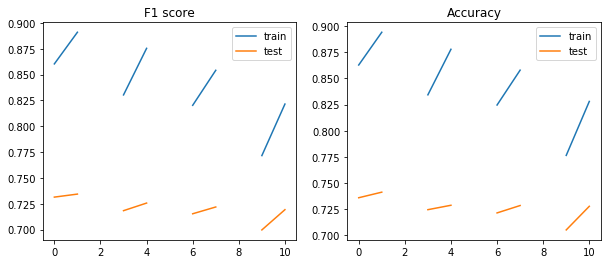

In [37]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('F1 score')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_f1_macro'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_f1_macro'], label='test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_accuracy'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_accuracy'], label='test')
plt.legend(loc='best')

## Čuvanje i evaluacija najboljeg modela

In [38]:
best_model = grid_f_cnn.best_estimator_

In [40]:
import joblib
joblib.dump(best_model, 'cnn_fft_new_dropout.joblib')

['cnn_fft_new_dropout.joblib']

In [41]:
y_pred = grid_f_cnn.predict(X_test_fft)

In [42]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.96      0.95       690
           2       0.61      0.56      0.59       690
           3       0.63      0.68      0.65       690
           4       0.88      0.82      0.85       690
           5       0.75      0.80      0.78       690

    accuracy                           0.76      3450
   macro avg       0.76      0.76      0.76      3450
weighted avg       0.76      0.76      0.76      3450



In [43]:
print(metrics.classification_report(y_test, y_pred, output_dict=True))

{'1': {'precision': 0.950937950937951, 'recall': 0.9550724637681159, 'f1-score': 0.953000723065799, 'support': 690}, '2': {'precision': 0.6125984251968504, 'recall': 0.563768115942029, 'f1-score': 0.5871698113207549, 'support': 690}, '3': {'precision': 0.6290322580645161, 'recall': 0.6782608695652174, 'f1-score': 0.6527196652719666, 'support': 690}, '4': {'precision': 0.8751926040061633, 'recall': 0.8231884057971014, 'f1-score': 0.8483943241224794, 'support': 690}, '5': {'precision': 0.7544581618655692, 'recall': 0.7971014492753623, 'f1-score': 0.7751937984496124, 'support': 690}, 'accuracy': 0.7634782608695653, 'macro avg': {'precision': 0.7644438800142102, 'recall': 0.7634782608695652, 'f1-score': 0.7632956644461225, 'support': 3450}, 'weighted avg': {'precision': 0.7644438800142099, 'recall': 0.7634782608695653, 'f1-score': 0.7632956644461225, 'support': 3450}}


In [44]:
print('Accuracy na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['accuracy'])

Accuracy na testnom skupu je  0.7634782608695653


In [45]:
print('F1 score na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score'])

F1 score na testnom skupu je  0.7632956644461225


In [46]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[659  23   1   6   1]
 [ 24 389 226  10  41]
 [  2 190 468   1  29]
 [  5   4   5 568 108]
 [  3  29  44  64 550]]


(5.5, -0.5)

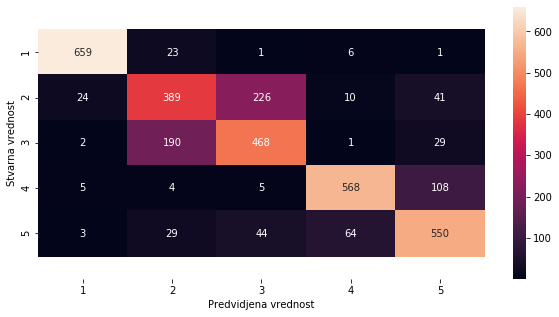

In [47]:
import seaborn
df_cm = pd.DataFrame(cm, index = classes, columns=classes)
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(df_cm, annot=True, fmt="d")
ax.set_ylabel('Stvarna vrednost')
ax.set_xlabel('Predvidjena vrednost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)